<a href="https://colab.research.google.com/github/Anuj-ipynb/Music-Genre-Recognition/blob/main/Music_Genre_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

##Kaggle API

In [ ]:

!pip install -q kaggle pydub
!apt-get install ffmpeg -y

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip -d gtzan

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace gtzan/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Definition and extraction of audio files using librosa and mel spectrograms

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']
def extract_mel_spectrogram(file_path, n_mels=128, show=False):
    try:
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(signal) < SAMPLES_PER_TRACK:
            signal = np.pad(signal, (0, SAMPLES_PER_TRACK - len(signal)))
        else:
            signal = signal[:SAMPLES_PER_TRACK]
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        if show:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel-frequency spectrogram')
            plt.tight_layout()
            plt.show()

        return mel_spec_db
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

##Loading Dataset and preprocessing and one hot encoding of datapoints

In [ ]:
def load_data(dataset_path):
    data = []
    labels = []
    for genre in GENRES:
        genre_path = os.path.join(dataset_path, genre)
        for filename in os.listdir(genre_path):
            if filename.endswith(".wav") or filename.endswith(".au"):
                file_path = os.path.join(genre_path, filename)
                mel = extract_mel_spectrogram(file_path)
                if mel is not None:
                    data.append(mel)
                    labels.append(genre)
    return np.array(data), np.array(labels)

def preprocess(dataset_path):
    X, y = load_data(dataset_path)
    X = X[..., np.newaxis]
    y = LabelEncoder().fit_transform(y)
    return train_test_split(X, y, test_size=0.2, random_state=42)



#Building Convolutional Neural Network model (runs 10 epochs)

In [ ]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


##Training the neural network model

<ipython-input-10-046d9dcb6f1b>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed to process gtzan/Data/genres_original/jazz/jazz.00054.wav: 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 292s 14s/step - accuracy: 0.0926 - loss: 43.6844 - val_accuracy: 0.1312 - val_loss: 2.2889
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 316s 16s/step - accuracy: 0.1191 - loss: 2.3189 - val_accuracy: 0.0625 - val_loss: 2.3034
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 289s 15s/step - accuracy: 0.1056 - loss: 2.3044 - val_accuracy: 0.0625 - val_loss: 2.3037
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 300s 15s/step - accuracy: 0.1265 - loss: 2.3017 - val_accuracy: 0.0625 - val_loss: 2.3045
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 315s 15s/step - accuracy: 0.1258 - loss: 2.3014 - val_accuracy: 0.0625 - val_loss: 2.3048
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 346s 16s/step - accuracy: 0.1124 - loss: 2.3017 - val_accuracy: 0.0625 - val_loss: 2.3053
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 294s 14s/step - accuracy: 0.0919 - loss: 2.3026 - val_accuracy: 0.0625 - val_loss: 2.3056
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 296s 15s/step - accuracy: 0.1101 - loss: 2.3017 - val_accuracy: 0

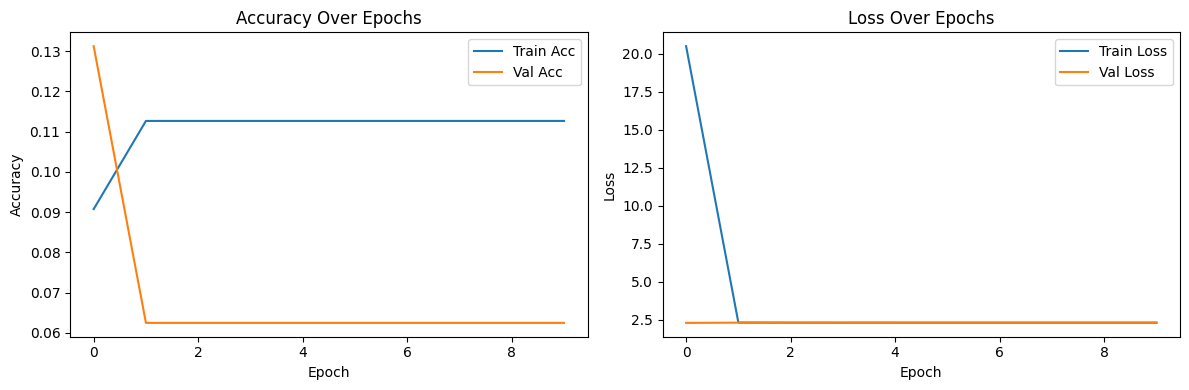

In [ ]:
def train_model(dataset_path):
    X_train, X_test, y_train, y_test = preprocess(dataset_path)
    model = build_model(X_train[0].shape, len(GENRES))
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test accuracy:", test_acc)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


#Predicting genres from new audio files

In [ ]:
def predict_genre(file_path, model):
    mel = extract_mel_spectrogram(file_path)
    if mel is None:
        return "Could not process audio."
    mel = mel[np.newaxis, ..., np.newaxis]
    prediction = model.predict(mel)
    predicted_index = np.argmax(prediction)
    return GENRES[predicted_index]

uploaded = files.upload()
file_path = list(uploaded.keys())[0]
genre = predict_genre(file_path, model)
print("Predicted Genre:", genre)


Saving solo2 - Copy.wav to solo2 - Copy.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted Genre: classical
